# A script for SLURM parallel processing of simulation data

Postprocessing regularly crashes my notebook, so I have to do it via SLURM jobs. This follows three steps:

- chunk the data via `fh.sublist`
- write to scratch (`/scratch/m/m300872/temp/`)
- open and join the files

This script launches a large cluster of SLURM jobs. The limit of jobs that can be processed in parallel is 20 (`MaxJobs`) and the maximum of jobs that can be queued is 1000 (`MaxJobsLimit`; both are counted per user and account, i.e. you can run more if you take advantage of multiple accounts. They can be checked via `sacctmgr list associations user=$USER`)

Additionally this bash function can help you check out how many job you are running at the moment (use like `njobs <account_name>`):
```bash
njobs ()
{ 
    local account_name=$1;
    squeue -u $USER -A "$account_name" --format="%i %T" | grep --color=auto -c PENDING
}
```

In case we encounter an error in the script (which has 499 copies still in the queue) we can cancel them via `fh.scancel_by_name`.

In [19]:
import os
import subprocess
import sys 

module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import file_handling as fh

def script(i): return f"""#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python                                   
#SBATCH --partition=compute
#SBATCH --account=bm1183
#SBATCH --time=02:00:00
#SBATCH --nodes=1
#SBATCH --mail-type=fail                                                                                                             
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import builtins
def print(*args, **kwargs):
        ''' for printing into SLURM logs'''
        builtins.print(*args, **kwargs, flush=True)

# THIS SCRIPT WAS AUTOMATICALLY GENERATED

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
fh.disable_warnings()
import postprocessing as pp
import xarray as xr
import numpy as np
import os

def get_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', time_index=None):
    datasets = [pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['surface'  , 'DOM01'])),
                pp.clean_surface_data(fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01']))]
    datasets = [ds.drop_duplicates(dim='time') for ds in datasets]
    data = xr.merge(datasets)

    data = add_control(data)
    if not time_index == None: data = data.isel(time=time_index)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))
    input_data = input_data.expand_dims(exp=('warming',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def add_variables(data):
    data['sou_t'].values = data['sou_t'].values * -1
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '+', 'sw_net')
    data = pp.add_arithmetic_variable(data, 'sw_net',  'thb_t',  '+', 'rad_net')
    data = pp.add_arithmetic_variable(data, 'shfl_s',  'lhfl_s', '+', 'fl_s')
    data = pp.add_arithmetic_variable(data, 'rad_net', 'fl_s',   '+', 'energyflux')
    data = pp.add_arithmetic_variable(data, 'sou_t',   'sod_t',  '/', 'albedo')
    return data
    
def process_dataset(data):
    data = pp.random_subsample(data, {{'cell':10000}})
    data = data.compute()
    data = data.where(np.isfinite(data), drop=True)
    #data = data.mean(dim='cell', keep_attrs=True)
    data = data.assign_coords(cell=np.arange(data.sizes['cell']))
    return data

def cloud_filter(data):
    unfiltered = data
    cloudy = pp.filter_by_threshold(data, {{'clct': 0.5}})
    clear_sky = pp.filter_by_threshold(data, {{'clct': 0.5}}, below_threshold=True)
    dimname, dimvalues = 'cloudcover', [0, 0.5, 1]
    processed_data = xr.concat([clear_sky, unfiltered, cloudy], dim=dimname)
    processed_data = processed_data.assign_coords({{dimname:(dimname, dimvalues)}})
    return processed_data

print('start')
print('i={str(i)}')
time_index = {i} #range(1143)
data = get_data(time_index=time_index)
data = add_variables(data)
data = pp.filter_by_threshold(data, {{'tqi_dia':1e-5}}, below_threshold=True)
data = process_dataset(data)
data = cloud_filter(data)
filename = f'/scratch/m/m300872/temp/dom01_if3_{{str(time_index[0]).rjust(4,"0")}}.nc'
print(filename)
if not os.path.exists(filename):
    print('writing')
    data.to_netcdf(filename)
else:
    print('exists')
print('done')
"""

script_name = '/scratch/m/m300872/temp/process.py'
njobs = 500
for i in range(500):
    print(i, end='')
    sublist = fh.sublist(range(1143), njobs, i)
    file_name = f'/scratch/m/m300872/temp/dom01_if3_{str(sublist[0]).rjust(4,"0")}.nc'
    if not os.path.exists(file_name):
        with open(script_name, 'w') as f: f.write(script(sublist))
        subprocess.call(['sbatch' ,script_name], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(', ', end='')
    else:
        print('-x, ', end='')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [5]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re#gex

def load_data(dirname = '/scratch/m/m300872/temp', 
              pattern = re.compile(r'^dom01_if3_\d{4}.*\.nc$')):
    file_list = [os.path.join(dirname, f) for f in os.listdir(dirname) if pattern.match(f)]
    data = xr.open_mfdataset(file_list)
    data['albedo'].values = data['albedo'].values * -1
    data = data.sortby(data.time)
    return data

def group_by_day(data):
    points_per_24h = int(pd.Timedelta('24H') / pd.to_timedelta(data.time.values[1] - data.time.values[0])) # determine the frequency
    chunk_index = xr.DataArray(np.arange(len(data.time)) // points_per_24h, dims='time', coords={'time': data.time})
    data = data.groupby(chunk_index).mean(skipna=True, keep_attrs=True).rename({'group':'day'})
    return data
    
data = load_data()
data

<xarray.Dataset> Size: 7GB
Dimensions:        (cloudcover: 3, exp: 2, time: 1143, cell: 10000)
Coordinates:
  * cell           (cell) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * exp            (exp) <U7 56B 'warming' 'control'
  * cloudcover     (cloudcover) float64 24B 0.0 0.5 1.0
  * time           (time) datetime64[ns] 9kB 2020-01-09T10:00:00 ... 2020-01-...
    lat            (time, cell) float64 91MB dask.array<chunksize=(3, 6590), meta=np.ndarray>
    lon            (time, cell) float64 91MB dask.array<chunksize=(3, 6590), meta=np.ndarray>
Data variables: (12/24)
    qv_2m          (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    tot_prec       (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    rain_gsp_rate  (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    sou_t          (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    t_2m           (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    shfl_s         (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    ...             ...
    v_10m          (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    sw_net         (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    rad_net        (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    fl_s           (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    energyflux     (cloudcover, exp, time, cell) float32 274MB dask.array<chunksize=(3, 2, 3, 6590), meta=np.ndarray>
    albedo         (cloudcover, exp, time, cell) float32 274MB nan ... nan
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

just a quick look into it:

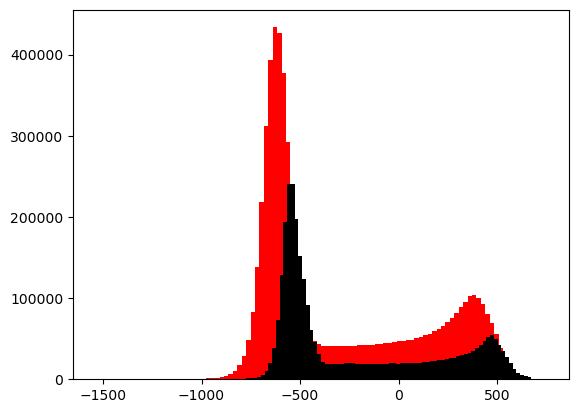

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(np.ravel(data.sel({'exp':'warming', 'cloudcover':0})['energyflux'].values), bins=100, color='red')
ax.hist(np.ravel(data.sel({'exp':'control', 'cloudcover':0})['energyflux'].values), bins=100, color='black')
fig.show()

In [8]:
target_file = '/scratch/m/m300872/temp/dom01_subset2.nc'
# target_file = './data/dom01_subset.nc'
data.to_netcdf(target_file)


KeyboardInterrupt



This was taking forever, so i went with another SLURM job, which just took 3 minutes:

In [12]:
#!/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/bin/python                                   
#SBATCH --partition=compute
#SBATCH --account=bm1183
#SBATCH --time=02:00:00
#SBATCH --nodes=1
#SBATCH --mail-type=fail                                                                                                             
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import builtins
def print(*args, **kwargs):
        ''' for printing into SLURM logs'''
        builtins.print(*args, **kwargs, flush=True)
    
import os
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import re#gex

def load_data(dirname = '/scratch/m/m300872/temp', 
              pattern = re.compile(r'^dom01_if3_\d{4}.*\.nc$')):
    file_list = [os.path.join(dirname, f) for f in os.listdir(dirname) if pattern.match(f)]
    data = xr.open_mfdataset(file_list)
    data['albedo'].values = data['albedo'].values * -1
    data = data.sortby(data.time)
    return data

def group_by_day(data):
    points_per_24h = int(pd.Timedelta('24H') / pd.to_timedelta(data.time.values[1] - data.time.values[0])) # determine the frequency
    chunk_index = xr.DataArray(np.arange(len(data.time)) // points_per_24h, dims='time', coords={'time': data.time})
    data = data.groupby(chunk_index).mean(skipna=True, keep_attrs=True).rename({'group':'day'})
    return data
    
data = load_data()
target_file = '/scratch/m/m300872/temp/dom01_subset3.nc'
data.to_netcdf(target_file) 

And this looks the same:

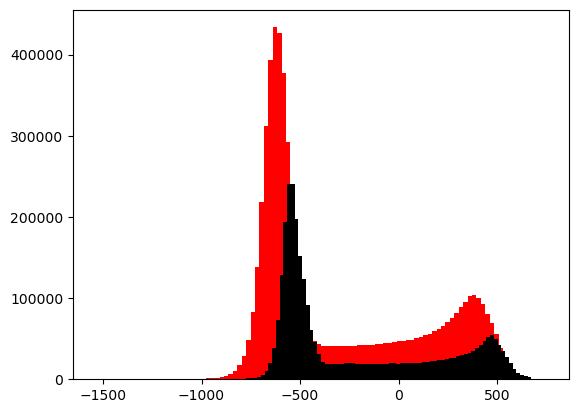

In [10]:
import matplotlib.pyplot as plt

data2 = xr.open_dataset('/scratch/m/m300872/temp/dom01_subset3.nc')

fig, ax = plt.subplots()
ax.hist(np.ravel(data2.sel({'exp':'warming', 'cloudcover':0})['energyflux'].values), bins=100, color='red')
ax.hist(np.ravel(data2.sel({'exp':'control', 'cloudcover':0})['energyflux'].values), bins=100, color='black')
fig.show()

And we'll copy this to that file to the repo, to enable us to do analysis when levante is down:

In [25]:
import subprocess

ifile = '/scratch/m/m300872/temp/dom01_subset3.nc'
ofile = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/dom01_subset.nc'

print(f'file size: {os.path.getsize(ifile)/1e9:.1f} GB')
print()

subprocess.call(['rsync', '-av', '--ignore-existing', '--progress', ifile, ofile])

file size: 6.8 GB

sending incremental file list
dom01_subset3.nc
  6,766,742,339 100%  406.53MB/s    0:00:15 (xfr#1, to-chk=0/1)

sent 6,768,394,485 bytes  received 35 bytes  410,205,728.48 bytes/sec
total size is 6,766,742,339  speedup is 1.00


0